# Hackathon Santo Digital

Esse Notebook foi criado com o intuito de resolver um case proposto pela Santo Digital com o objetivo de criar um modelo de machine learning que possa prever a demanda de vendas de um produto específico para o próximo mês. referente ao desafio de número IV

As etapas propostas foram:
1. Análise Exploratória de Dados (EDA);
2. Pré-processamento de Dados;
3. Feature Engineering;
4. Modelagem;
5. Ajuste de modelo.


## Unificando os relatórios de Sales

In [421]:
import pandas as pd

file_paths = ['/content/AdventureWorks_Sales_2015.csv', '/content/AdventureWorks_Sales_2016.csv', '/content/AdventureWorks_Sales_2017.csv']  # Substitua pelos nomes dos seus arquivos

dfs = []

for file_path in file_paths:
  df = pd.read_csv(file_path)
  dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df.to_csv('/content/Sales.csv', index=False)


In [422]:
sales = pd.read_csv('/content/Sales.csv')

In [423]:
sales.columns

Index(['OrderDate', 'StockDate', 'OrderNumber', 'ProductKey', 'CustomerKey',
       'TerritoryKey', 'OrderLineItem', 'OrderQuantity'],
      dtype='object')

#### Carregando os demais arquivos csv


In [424]:
# Carregar os CSVs
customers = pd.read_csv('/content/AdventureWorks_Customers.csv', encoding='latin-1')
products = pd.read_csv('/content/AdventureWorks_Products.csv')
categories = pd.read_csv('/content/AdventureWorks_Product_Categories.csv')
subcategories = pd.read_csv('/content/AdventureWorks_Product_Subcategories.csv')
returns = pd.read_csv('/content/AdventureWorks_Returns.csv')
territories = pd.read_csv('/content/AdventureWorks_Territories.csv')

In [425]:
# Converter OrderDate para datetime e extrair informações de tempo
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])
sales['Month'] = sales['OrderDate'].dt.month
sales['Year'] = sales['OrderDate'].dt.year

#### Unindo datasets

Nesta etapa eu estarei estreitando relacionamentos entre os arquivos para que consiga pegar as informações desejadas e unir em um unico dataset.

Aqui já estarei fazendo algumas tratativas de feasture engineering mais básicas, como extrair idade do campo de data de nascimento.

In [426]:
# Adicionar informações de produtos
sales = sales.merge(products, on='ProductKey', how='left')

In [427]:
# Adicionar informações de clientes
sales = sales.merge(customers, on='CustomerKey', how='left')

In [428]:
# Estou considerando o current_year como 2017, pois, devido a quantidade de vendas no dataset 'Sales_2017', aparenta ter vendas até o mês 7,
# o que possivelmente indicaria que ainda estariamos em 2017.

current_year = 2017
sales['Age'] = current_year - pd.to_datetime(sales['BirthDate']).dt.year

In [429]:
# Adicionar categorias e subcategorias de produtos
sales = sales.merge(subcategories, on='ProductSubcategoryKey', how='left')
sales = sales.merge(categories, on='ProductCategoryKey', how='left')

In [430]:
# Adicionar informações territoriais
sales = sales.merge(territories, left_on='TerritoryKey', right_on='SalesTerritoryKey', how='left')

In [431]:
# Visualizando as colunas de Sales após uniões
sales.columns

Index(['OrderDate', 'StockDate', 'OrderNumber', 'ProductKey', 'CustomerKey',
       'TerritoryKey', 'OrderLineItem', 'OrderQuantity', 'Month', 'Year',
       'ProductSubcategoryKey', 'ProductSKU', 'ProductName', 'ModelName',
       'ProductDescription', 'ProductColor', 'ProductSize', 'ProductStyle',
       'ProductCost', 'ProductPrice', 'Prefix', 'FirstName', 'LastName',
       'BirthDate', 'MaritalStatus', 'Gender', 'EmailAddress', 'AnnualIncome',
       'TotalChildren', 'EducationLevel', 'Occupation', 'HomeOwner', 'Age',
       'SubcategoryName', 'ProductCategoryKey', 'CategoryName',
       'SalesTerritoryKey', 'Region', 'Country', 'Continent'],
      dtype='object')

In [432]:
# Selecionando as colunas para o dataset final
final_dataset = sales[[
            'OrderDate', 'Month', 'Year',  'ProductName',
            'SubcategoryName', 'CategoryName', 'ProductColor', 'ProductSize', 'ProductStyle',
            'ProductCost', 'ProductPrice', 'Prefix', 'FirstName', 'LastName',  'Age', 'MaritalStatus',
            'Gender', 'AnnualIncome', 'TotalChildren', 'EducationLevel', 'HomeOwner',
            'Occupation', 'Region', 'Country', 'Continent',
            'OrderQuantity'
        ]]

In [433]:
# Tirando o _x do nome das colunas
final_dataset = final_dataset.rename(columns=lambda x: x.rstrip('_x'))
final_dataset = final_dataset.rename(columns={'Prefi': 'Prefix'})

In [434]:
final_dataset.columns

Index(['OrderDate', 'Month', 'Year', 'ProductName', 'SubcategoryName',
       'CategoryName', 'ProductColor', 'ProductSize', 'ProductStyle',
       'ProductCost', 'ProductPrice', 'Prefix', 'FirstName', 'LastName', 'Age',
       'MaritalStatus', 'Gender', 'AnnualIncome', 'TotalChildren',
       'EducationLevel', 'HomeOwner', 'Occupation', 'Region', 'Country',
       'Continent', 'OrderQuantity'],
      dtype='object')

In [435]:
# Salvando como um novo csv
final_dataset.to_csv('/content/final_dataset.csv', index=False)

#### Conclusão da etapa
Os dados extraídos para análise exploratória foram:

* Temporal: OrderDate, Month, Year
* Product: ProductName, SubcategoryName, ProductColor, ProductSize, ProductStyle, ProductCost, ProductPrice
* Customer: FirstName, LastName, Prefix, Age, MaritalStatus, Gender, AnnualIncome, TotalChildren, EducationLevel, HomeOwner, Occupation
* Geographic: Region, Country, Continent
* Order: OrderQuantity (Target)

## Análise Exploratória de Dados (EDA)

In [436]:
# Copiando o dataset para outro DataFrame com nome mais curto para facilitar a escrita do código
df = final_dataset.copy()

#### Dados Nulos

A única coluna com dados nulos é a de ProductColor, Prefix e Gender

In [437]:
# Identificando possíveis dados nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56046 entries, 0 to 56045
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderDate        56046 non-null  datetime64[ns]
 1   Month            56046 non-null  int32         
 2   Year             56046 non-null  int32         
 3   ProductName      56046 non-null  object        
 4   SubcategoryName  56046 non-null  object        
 5   CategoryName     56046 non-null  object        
 6   ProductColor     29168 non-null  object        
 7   ProductSize      56046 non-null  object        
 8   ProductStyle     56046 non-null  object        
 9   ProductCost      56046 non-null  float64       
 10  ProductPrice     56046 non-null  float64       
 11  Prefix           55666 non-null  object        
 12  FirstName        56046 non-null  object        
 13  LastName         56046 non-null  object        
 14  Age              56046 non-null  int32

In [438]:
df.describe()

,OrderDate,Month,Year,ProductCost,ProductPrice,Age,TotalChildren,OrderQuantity
count,56046,56046.000000,56046.000000,56046.000000,56046.000000,56046.000000,56046.000000,56046.000000
mean,2016-12-16 18:39:22.487956224,6.296631,2016.479089,255.750403,438.969347,55.350890,1.843985,1.501873
min,2015-01-01 00:00:00,1.000000,2015.000000,0.856500,2.290000,37.000000,0.000000,1.000000
25%,2016-10-06 00:00:00,3.000000,2016.000000,2.973300,7.950000,47.000000,0.000000,1.000000
50%,2017-01-11 00:00:00,6.000000,2017.000000,11.216300,29.990000,54.000000,2.000000,1.000000
75%,2017-04-12 00:00:00,10.000000,2017.000000,59.466000,159.000000,63.000000,3.000000,2.000000
max,2017-06-30 00:00:00,12.000000,2017.000000,2171.294200,3578.270000,107.000000,5.000000,3.000000
std,NaN,3.526167,0.586021,496.192920,838.650049,11.013478,1.619434,0.612379


#### Visualizações

In [439]:
# Importando dependências
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [440]:
# Estatísticas descritivas gerais
print(df['OrderQuantity'].describe())

count    56046.000000
mean         1.501873
std          0.612379
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: OrderQuantity, dtype: float64


In [441]:
# Estatísticas descritivas segmentadas por região
print(df.groupby('Region')['OrderQuantity'].describe())

                  count      mean       std  min  25%  50%  75%  max
Region                                                              
Australia       12409.0  1.446611  0.598924  1.0  1.0  1.0  2.0  3.0
Canada           6875.0  1.584582  0.629223  1.0  1.0  2.0  2.0  3.0
Central            20.0  1.500000  0.606977  1.0  1.0  1.0  2.0  3.0
France           5239.0  1.500668  0.607599  1.0  1.0  1.0  2.0  3.0
Germany          5289.0  1.503120  0.616558  1.0  1.0  1.0  2.0  3.0
Northeast          27.0  1.481481  0.579812  1.0  1.0  1.0  2.0  3.0
Northwest        8267.0  1.513608  0.609945  1.0  1.0  1.0  2.0  3.0
Southeast          34.0  1.441176  0.560907  1.0  1.0  1.0  2.0  3.0
Southwest       11463.0  1.499695  0.613476  1.0  1.0  1.0  2.0  3.0
United Kingdom   6423.0  1.509264  0.611221  1.0  1.0  1.0  2.0  3.0


In [442]:
# Estatísticas descritivas segmentadas por categoria de produto
print(df.groupby('CategoryName')['OrderQuantity'].describe())

                count      mean       std  min  25%  50%  75%  max
CategoryName                                                      
Accessories   33607.0  1.720148  0.616072  1.0  1.0  2.0  2.0  3.0
Bikes         13929.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
Clothing       8510.0  1.461340  0.607353  1.0  1.0  1.0  2.0  3.0


In [443]:
# Vendas por região
sales_by_region = df.groupby('Region')['OrderQuantity'].sum().reset_index()
sales_by_region.sort_values(by='OrderQuantity', ascending=False, inplace=True)
sales_by_region

,Region,OrderQuantity
0,Australia,17951
8,Southwest,17191
6,Northwest,12513
1,Canada,10894
9,United Kingdom,9694
4,Germany,7950
3,France,7862
7,Southeast,49
5,Northeast,40
2,Central,30


In [444]:
# Vendas por categoria de produto
sales_by_category = df.groupby('CategoryName')['OrderQuantity'].sum().reset_index()
sales_by_category.sort_values(by='OrderQuantity', ascending=False, inplace=True)
sales_by_category

,CategoryName,OrderQuantity
0,Accessories,57809
1,Bikes,13929
2,Clothing,12436


#### Distribuição de Vendas ao Longo do Tempo (Histograma)

É possível identificar que, a partir da metade do ano ed 2016, as vendas alavancaram muito

In [445]:
# Configurações dos gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

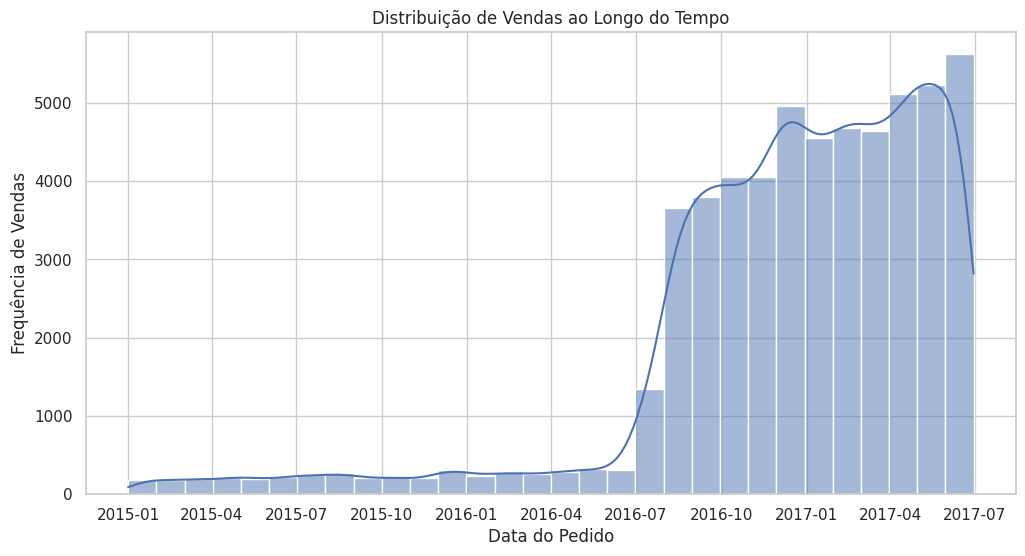

In [446]:
sns.histplot(df, x='OrderDate', kde=True, bins=30)
plt.title('Distribuição de Vendas ao Longo do Tempo')
plt.xlabel('Data do Pedido')
plt.ylabel('Frequência de Vendas')
plt.show()

<ipython-input-447-34cbc1b5fbf6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='OrderQuantity', data=sales_by_region, palette='viridis')


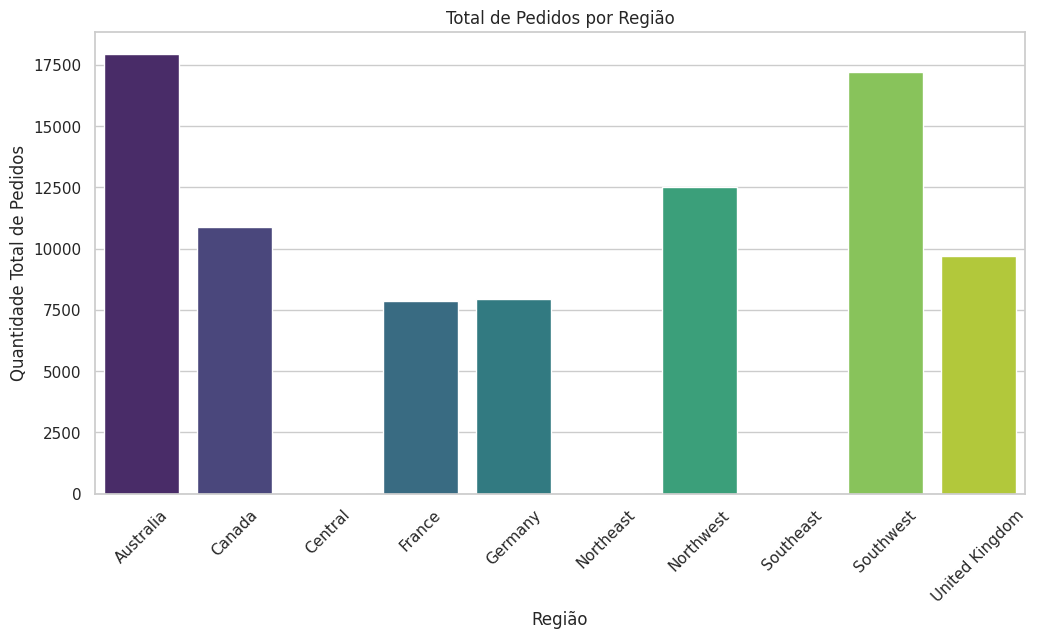

In [447]:
# Gráfico de barras para Vendas Totais por Região
sales_by_region = df.groupby('Region')['OrderQuantity'].sum().reset_index()
sns.barplot(x='Region', y='OrderQuantity', data=sales_by_region, palette='viridis')
plt.title('Total de Pedidos por Região')
plt.xlabel('Região')
plt.ylabel('Quantidade Total de Pedidos')
plt.xticks(rotation=45)
plt.show()

<ipython-input-448-0187c85a852a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CategoryName', y='OrderQuantity', data=sales_by_category, palette='coolwarm')


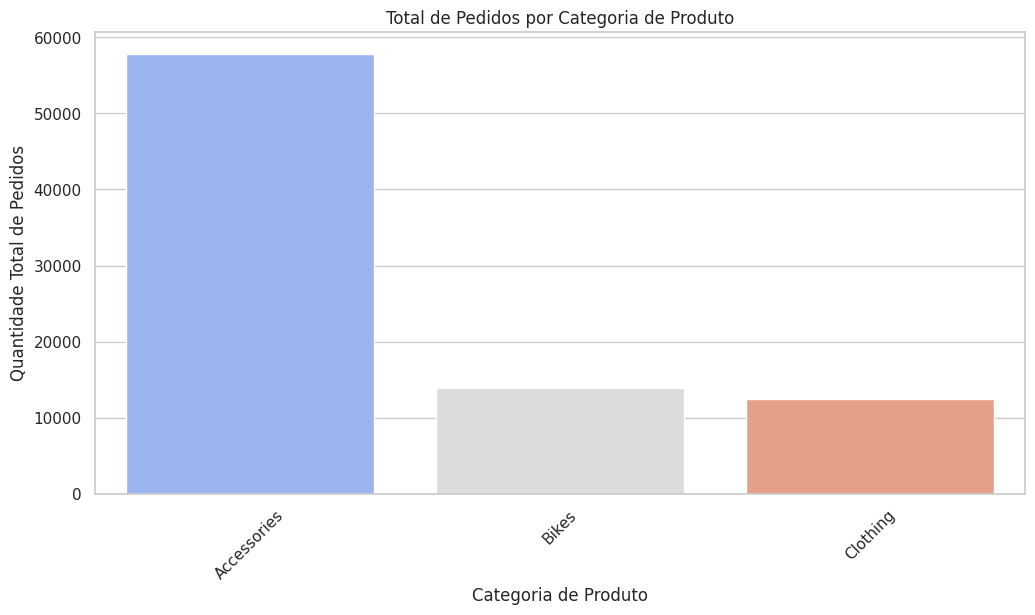

In [448]:
# Vendas por Categoria de Produto
sales_by_category = df.groupby('CategoryName')['OrderQuantity'].sum().reset_index()
sns.barplot(x='CategoryName', y='OrderQuantity', data=sales_by_category, palette='coolwarm')
plt.title('Total de Pedidos por Categoria de Produto')
plt.xlabel('Categoria de Produto')
plt.ylabel('Quantidade Total de Pedidos')
plt.xticks(rotation=45)
plt.show()

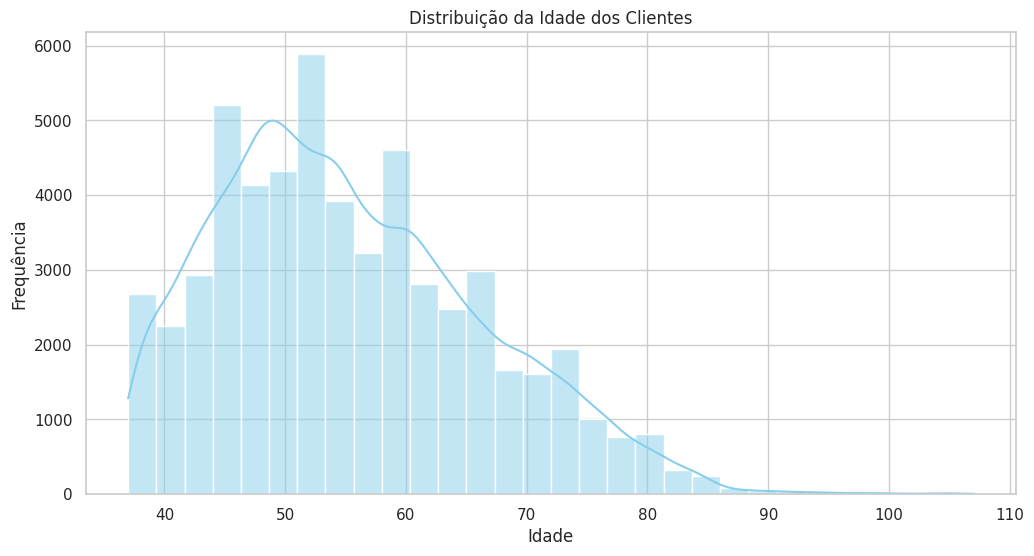

In [449]:
# Análise da Distribuição de Idade
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue')
plt.title('Distribuição da Idade dos Clientes')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

<ipython-input-450-163806b48208>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ProductSize', y='OrderQuantity', data=sales_by_size, palette='Dark2')


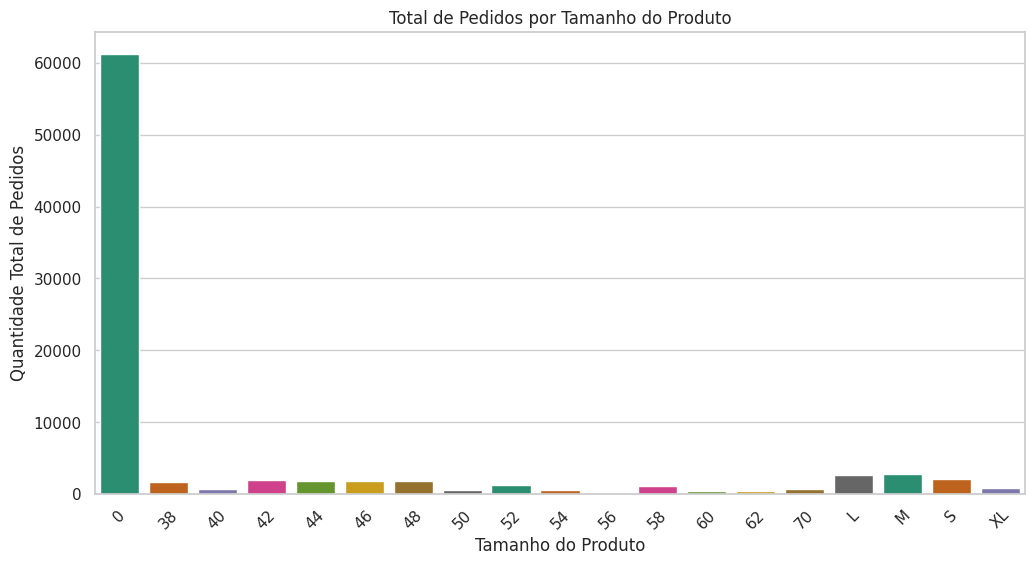

In [450]:
# Análise de vendas por Tamanho do Produto
sales_by_size = df.groupby('ProductSize')['OrderQuantity'].sum().reset_index()
sns.barplot(x='ProductSize', y='OrderQuantity', data=sales_by_size, palette='Dark2')
plt.title('Total de Pedidos por Tamanho do Produto')
plt.xlabel('Tamanho do Produto')
plt.ylabel('Quantidade Total de Pedidos')
plt.xticks(rotation=45)
plt.show()


<ipython-input-451-23f2b5e28904>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ProductColor', y='OrderQuantity', data=sales_by_color, palette='Paired')


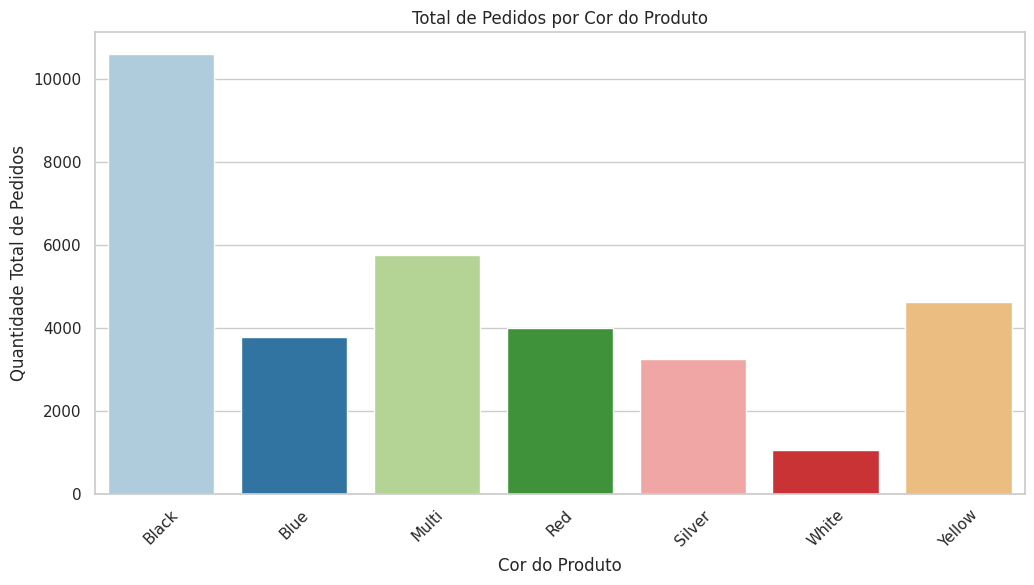

In [451]:
# Análise de vendas por Cor do Produto
plt.figure(figsize=(12, 6))
sales_by_color = df.groupby('ProductColor')['OrderQuantity'].sum().reset_index()
sns.barplot(x='ProductColor', y='OrderQuantity', data=sales_by_color, palette='Paired')
plt.title('Total de Pedidos por Cor do Produto')
plt.xlabel('Cor do Produto')
plt.ylabel('Quantidade Total de Pedidos')
plt.xticks(rotation=45)
plt.show()

#### Preço vs Quantidade de Vendas (Scatterplot)

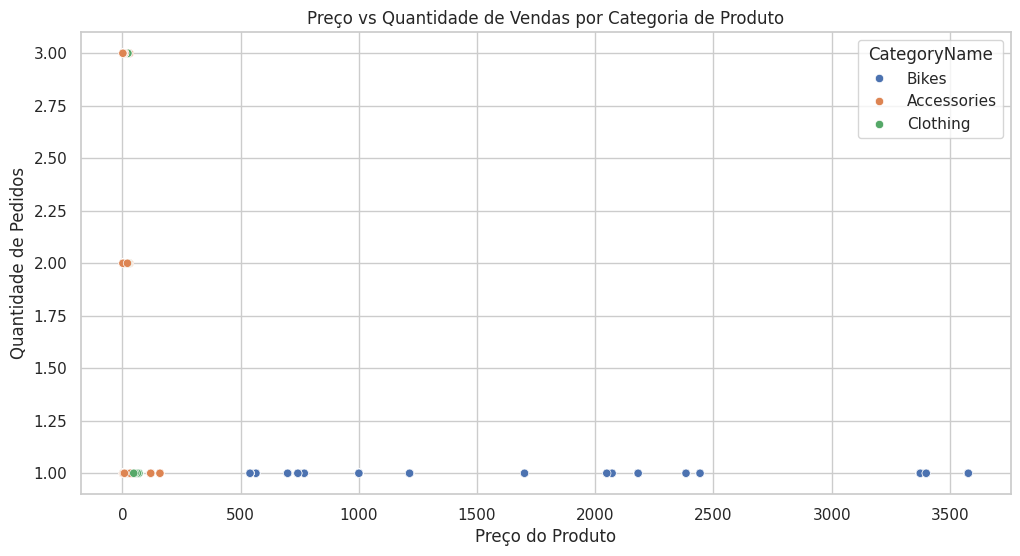

In [452]:
sns.scatterplot(x='ProductPrice', y='OrderQuantity', hue='CategoryName', data=df)
plt.title('Preço vs Quantidade de Vendas por Categoria de Produto')
plt.xlabel('Preço do Produto')
plt.ylabel('Quantidade de Pedidos')
plt.show()

#### Identificação de outliers

In [453]:
# Calculando os quartis e o IQR
Q1 = df['OrderQuantity'].quantile(0.25)
Q3 = df['OrderQuantity'].quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")

Q1: 1.0, Q3: 2.0, IQR: 1.0


In [454]:
# Definindo limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

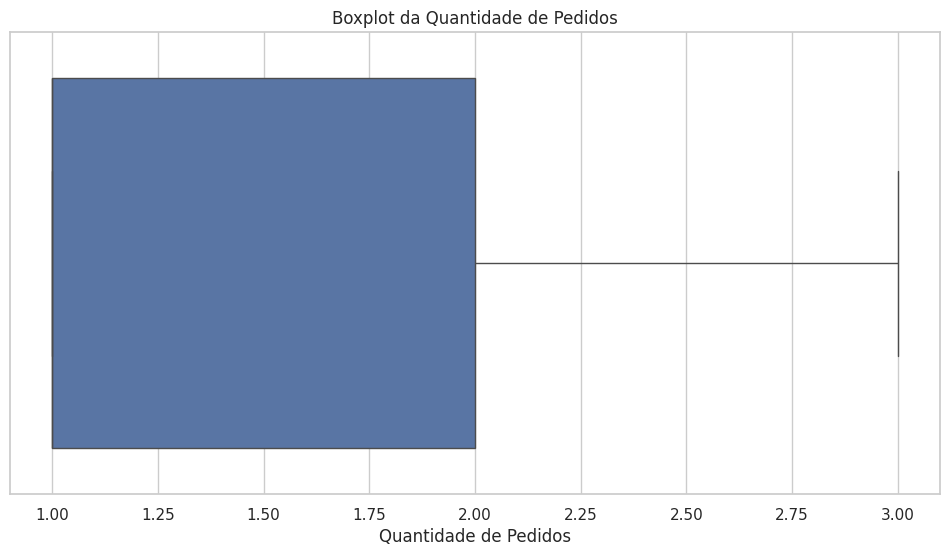

In [455]:
# Visualizando os outliers com boxplot
sns.boxplot(x='OrderQuantity', data=df)
plt.title('Boxplot da Quantidade de Pedidos')
plt.xlabel('Quantidade de Pedidos')
plt.show()

In [456]:
# Identificando outliers
outliers = df[(df['OrderQuantity'] < lower_bound) | (df['OrderQuantity'] > upper_bound)]
print("Número de outliers identificados:", len(outliers))

Número de outliers identificados: 0


In [457]:
from scipy import stats

In [458]:
# Calculando o Z-score
z_scores = np.abs(stats.zscore(df['OrderQuantity']))
outliers_z = df[z_scores > 3]
print("Número de outliers identificados pelo Z-score:", len(outliers_z))

Número de outliers identificados pelo Z-score: 0


## Pré-processamento de Dados

Tratando os campos de valor ProductCost e ProductPrice

In [459]:
# Remover caracteres não numéricos da coluna 'AnnualIncome' e converter para float
df['AnnualIncome'] = df['AnnualIncome'].replace('[\$,]', '', regex=True).astype(float)

Como já tinha sido identificado antes, as features com dados faltantes são, ProductColor, Prefix e Gender

In [460]:
df['Gender'].unique()

array(['M', 'F', nan], dtype=object)

In [461]:
# Criando um novo dataset para tratar os Gêneros faltantes
filtro = df['Gender'].isna()

na_genders = df[filtro]
with_genders = df[~filtro]

with_genders = with_genders[['FirstName', 'LastName', 'Gender']]
na_genders = na_genders[['FirstName', 'LastName', 'Gender']]

#### Tratando feature Gender

Foram pensadas duas formas que podem ser feitas para resolver esses dados faltantes
1. Identificar todos os nomes com dados faltanes e criar um dicionário para aplicar a troca
2. Identificar os nomes que já existem com gêneros atrelados e associar o mesmo valor

In [462]:
na_genders['FirstName'].unique()

array(['RICKY', 'HAROLD', 'ANGELA', 'DENNIS', 'VANESSA', 'JENNY', 'JÉSUS',
       'JASMINE', 'ORLANDO', 'TODD', 'NANCY', 'ALISHA', 'PEDRO',
       'CYNTHIA', 'MICAH', 'IAN', 'ARTHUR', 'EDDIE', 'NICOLAS', 'KRISTI',
       'ADRIANA', 'ALEJANDRO', 'TERESA', 'KATHERINE', 'NINA', 'ANNA',
       'KATIE', 'JAMIE', 'JACQUELINE', 'ALEXANDER', 'NATHANIEL', 'RUTH',
       'KRISTINE', 'LUKE', 'ROBYN', 'DARREN', 'WYATT', 'ALEXA', 'TONYA',
       'JONATHAN', 'LOUIS', 'CRAIG', 'NAOMI', 'THOMAS', 'CESAR', 'MIGUEL',
       'JACK', 'SHEILA', 'EMILY', 'LEVI', 'MARCUS', 'CANDICE', 'DALTON',
       'MARIE', 'SHAWN', 'TAMMY', 'CATHERINE', 'KEITH', 'TERRY', 'DIANA',
       'MINDY', 'BRETT', 'LATOYA', 'CEDRIC', 'JAN', 'GERALD', 'MADISON',
       'LESLIE', 'FERNANDO', 'BARBARA', 'EDWARD', 'MISTY', 'RACHEL',
       'GAIL', 'LUIS', 'SHANNON', 'SAVANNAH', 'EMMA', 'REGINALD',
       'BRIANNA', 'ALEXANDRA', 'DAISY', 'WENDY', 'CHRISTY', 'AMANDA',
       'RICARDO', 'JEROME', 'RENEE', 'JESSIE', 'ALEXANDRIA', 'JASON',


In [463]:
with_genders['FirstName'].unique()

array(['JOHN', 'KYLE', 'ROSS', 'SETH', 'ALEJANDRO', 'GRACE', 'JACQUELYN',
       'REGINALD', 'ADRIENNE', 'ALEXANDRA', 'COLIN', 'GLENN', 'JENNA',
       'JODI', 'JOSEPH', 'OSCAR', 'AMANDA', 'CAROLINE', 'DAWN', 'GEORGE',
       'RICHARD', 'ADAM', 'ERIC', 'MIGUEL', 'ASHLEY', 'COURTNEY', 'LUIS',
       'TAYLOR', 'BRENDAN', 'BRIANNA', 'LATASHA', 'RICARDO', 'ANNA',
       'AUSTIN', 'IAN', 'ISABELLA', 'JONATHON', 'SUZANNE', 'VICTORIA',
       'DENISE', 'MORGAN', 'KATRINA', 'MEREDITH', 'COLLEEN', 'DALTON',
       'EDUARDO', 'ERIKA', 'JUSTIN', 'MASON', 'RILEY', 'EVAN', 'JANET',
       'KATHERINE', 'TARA', 'VERONICA', 'WAYNE', 'BRYANT', 'JAIME',
       'MARIA', 'EMMA', 'GARY', 'JERRY', 'JULIA', 'LATOYA', 'LOUIS',
       'MATHEW', 'REGINA', 'SYDNEY', 'ANDY', 'CHERYL', 'DARREN',
       'FRANKLIN', 'STANLEY', 'DARRYL', 'FRANCISCO', 'LAURA', 'STEVEN',
       'TAMARA', 'WYATT', 'DEANNA', 'ERIN', 'FAITH', 'JON', 'XAVIER',
       'CASEY', 'ERNEST', 'MARIO', 'PETER', 'STEVE', 'THERESA', 'EDWIN',
       

In [464]:
maping_gender = with_genders.set_index('FirstName')['Gender'].to_dict()

In [465]:
# Função para preencher o gênero com base no mapeamento
def preencher_genero(nome):
    return maping_gender.get(nome, 'Unknown')

##### DF Cópia

In [466]:
# Aplica a função para preencher o gênero
df2 = df.copy() # Testando com a copia do df original
df2.loc[df2['Gender'].isna(), 'Gender'] = df2.loc[df2['Gender'].isna(), 'FirstName'].apply(preencher_genero)

print(df2[['FirstName', 'LastName', 'Gender']])

       FirstName    LastName Gender
0           JOHN      THOMAS      M
1           KYLE  WASHINGTON      M
2           ROSS        SANZ      M
3           SETH       LEWIS      M
4      ALEJANDRO        CHEN      M
...          ...         ...    ...
56041       TROY    GONZALEZ      M
56042       TROY    GONZALEZ      M
56043       TROY    GONZALEZ      M
56044    VALERIE         GUO      F
56045    VALERIE         GUO      F

[56046 rows x 3 columns]


In [467]:
df2[df2['Gender'] == 'Unknown']

,OrderDate,Month,Year,ProductName,SubcategoryName,CategoryName,ProductColor,ProductSize,ProductStyle,ProductCost,...,Gender,AnnualIncome,TotalChildren,EducationLevel,HomeOwner,Occupation,Region,Country,Continent,OrderQuantity


In [468]:
df2['Gender'].unique()

array(['M', 'F'], dtype=object)

##### DF Original
Agora que eu garanti que todos os gêneros foram preenchidos, posso fazer o mesmo com o dataframe original 'df'

In [469]:
# Aplica a função para preencher o gênero
df.loc[df['Gender'].isna(), 'Gender'] = df.loc[df['Gender'].isna(), 'FirstName'].apply(preencher_genero)

In [470]:
df['Gender'].unique()

array(['M', 'F'], dtype=object)

#### Tratando feature Prefix

Para tratar os Prefixos, posso utilizar a mesma técnica, porém, podem ter variancias, já que MRS. e MS. podem mudar baseado no MartialStatus das pessoas do Gênero Feminino.

As duas abordagens que posso seguir são:
1. Considerar que toda mulher casada usa o Prefix MRS. e as demais MS.
2. Ignorar o MartialStatus e tratar todas as faltantes como MS., já que, no dataset, não é utilizado o Prefix Miss para Não Casadas.

In [471]:
df['Prefix'].unique()

array(['MR.', 'MRS.', 'MS.', nan], dtype=object)

In [472]:
df['MaritalStatus'].unique()

array(['M', 'S'], dtype=object)

In [473]:
def preencher_prefix(row):
    if row['Gender'] == 'F' and row['MaritalStatus'] == 'M':
        return 'MRS.'
    elif row['Gender'] == 'F' and row['MaritalStatus'] == 'S':
        return 'MS.'
    elif row['Gender'] == 'M':
        return 'MR.'

##### DF Cópia

In [474]:
# Aplica a função apenas nas linhas onde 'Prefix' é nulo
df3 = df.copy()
df3.loc[df3['Prefix'].isna(), 'Prefix'] = df3[df3['Prefix'].isna()].apply(preencher_prefix, axis=1)

In [475]:
df3['Prefix'].unique()

array(['MR.', 'MRS.', 'MS.'], dtype=object)

In [476]:
df3.loc[df3['Gender'] == 'M', 'Prefix'].unique() # Garantindo que toda pessoa do Gênero M seja 'MR.'

array(['MR.'], dtype=object)

##### DF Original
Agora que eu garanti que todos os Prefix foram preenchidos, posso fazer o mesmo com o dataframe original 'df'

In [477]:
df.loc[df['Prefix'].isna(), 'Prefix'] = df[df['Prefix'].isna()].apply(preencher_prefix, axis=1)

In [478]:
df['Prefix'].unique()

array(['MR.', 'MRS.', 'MS.'], dtype=object)

In [479]:
df.loc[df['Gender'] == 'M', 'Prefix'].unique()

array(['MR.'], dtype=object)

#### Tratando feature ProductColor

In [480]:
df['ProductColor'].unique()

array(['Black', 'Red', 'Silver', 'Yellow', nan, 'Blue', 'Multi', 'White'],
      dtype=object)

In [481]:
def verificar_cores_por_produto(df):
    grouped = df.groupby('ProductName')['ProductColor'].unique()
    dicionario_cores = grouped.to_dict()

    return dicionario_cores

In [482]:
product_colors = verificar_cores_por_produto(df)
product_colors

{'AWC Logo Cap': array(['Multi'], dtype=object),
 'All-Purpose Bike Stand': array([nan], dtype=object),
 'Bike Wash - Dissolver': array([nan], dtype=object),
 'Classic Vest, L': array(['Blue'], dtype=object),
 'Classic Vest, M': array(['Blue'], dtype=object),
 'Classic Vest, S': array(['Blue'], dtype=object),
 'Fender Set - Mountain': array([nan], dtype=object),
 'HL Mountain Tire': array([nan], dtype=object),
 'HL Road Tire': array([nan], dtype=object),
 'Half-Finger Gloves, L': array(['Black'], dtype=object),
 'Half-Finger Gloves, M': array(['Black'], dtype=object),
 'Half-Finger Gloves, S': array(['Black'], dtype=object),
 'Hitch Rack - 4-Bike': array([nan], dtype=object),
 'Hydration Pack - 70 oz.': array(['Silver'], dtype=object),
 'LL Mountain Tire': array([nan], dtype=object),
 'LL Road Tire': array([nan], dtype=object),
 'Long-Sleeve Logo Jersey, L': array(['Multi'], dtype=object),
 'Long-Sleeve Logo Jersey, M': array(['Multi'], dtype=object),
 'Long-Sleeve Logo Jersey, S': arr

In [483]:
df_nan = df[df['ProductColor'].isna()]
dict_colorsnan = verificar_cores_por_produto(df_nan)
dict_colorsnan

{'All-Purpose Bike Stand': array([nan], dtype=object),
 'Bike Wash - Dissolver': array([nan], dtype=object),
 'Fender Set - Mountain': array([nan], dtype=object),
 'HL Mountain Tire': array([nan], dtype=object),
 'HL Road Tire': array([nan], dtype=object),
 'Hitch Rack - 4-Bike': array([nan], dtype=object),
 'LL Mountain Tire': array([nan], dtype=object),
 'LL Road Tire': array([nan], dtype=object),
 'ML Mountain Tire': array([nan], dtype=object),
 'ML Road Tire': array([nan], dtype=object),
 'Mountain Bottle Cage': array([nan], dtype=object),
 'Mountain Tire Tube': array([nan], dtype=object),
 'Patch Kit/8 Patches': array([nan], dtype=object),
 'Road Bottle Cage': array([nan], dtype=object),
 'Road Tire Tube': array([nan], dtype=object),
 'Touring Tire': array([nan], dtype=object),
 'Touring Tire Tube': array([nan], dtype=object),
 'Water Bottle - 30 oz.': array([nan], dtype=object)}

Fazendo uma pesquisa rápida na internet sobre cada produto, pode-se concluir que maior parte desses itens são de cor preta ou onde a cor é irrelevante, logo, posso seguir as seguintes opções

1. Todos os Produtos que são 'Tires' ou associados a ela, como os 'Patches', posso declara-las como 'Black'.
2. Os "Gadgets" para bicicleta também podem ser consideradas como 'Black'.
3. 'Water Bottle' e 'Bike Wash' são os produtos onde a cor pode ser diversa, bastaria identificar quantos são comprados e considerar eles como a cor 'Multi'

##### DF Cópia

In [484]:
# Filtrar os itens que possuem 'Tire' no nome e cor como NaN
df4 = df.copy()
filtro_tire_sem_cor = (df4['ProductName'].str.contains('Tire')) & (df4['ProductColor'].isna())

In [485]:
# Substituir os valores NaN na coluna 'ProductColor' por 'Black'
df4.loc[filtro_tire_sem_cor, 'ProductColor'] = 'Black'

In [486]:
# Filtrar os itens que possuem 'Water Bottle|Bike Wash]' no nome e cor como NaN
filtro_water_bike_sem_cor = (df4['ProductName'].str.contains('Water Bottle|Bike Wash')) & (df4['ProductColor'].isna())

In [487]:
# Substituir os valores NaN na coluna 'ProductColor' por 'Multi'
df4.loc[filtro_water_bike_sem_cor, 'ProductColor'] = 'Multi'

In [488]:
# Colocando os demais produtos como ProductColor = 'Black'
df4['ProductColor'] = df4['ProductColor'].fillna('Black')

In [489]:
# Verificando se ainda existem dados nulos
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56046 entries, 0 to 56045
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderDate        56046 non-null  datetime64[ns]
 1   Month            56046 non-null  int32         
 2   Year             56046 non-null  int32         
 3   ProductName      56046 non-null  object        
 4   SubcategoryName  56046 non-null  object        
 5   CategoryName     56046 non-null  object        
 6   ProductColor     56046 non-null  object        
 7   ProductSize      56046 non-null  object        
 8   ProductStyle     56046 non-null  object        
 9   ProductCost      56046 non-null  float64       
 10  ProductPrice     56046 non-null  float64       
 11  Prefix           56046 non-null  object        
 12  FirstName        56046 non-null  object        
 13  LastName         56046 non-null  object        
 14  Age              56046 non-null  int32

##### DF Original
Agora que eu garanti que todos os ProductColor foram preenchidos, posso fazer o mesmo com o dataframe original 'df'

In [490]:
# Filtrar os itens que possuem 'Tire' no nome e cor como NaN
filtro_tire_sem_cor = (df['ProductName'].str.contains('Tire')) & (df['ProductColor'].isna())

In [491]:
# Substituir os valores NaN na coluna 'ProductColor' por 'Black'
df.loc[filtro_tire_sem_cor, 'ProductColor'] = 'Black'

In [492]:
# Filtrar os itens que possuem 'Water Bottle|Bike Wash]' no nome e cor como NaN
filtro_water_bike_sem_cor = (df['ProductName'].str.contains('Water Bottle|Bike Wash')) & (df['ProductColor'].isna())

In [493]:
# Substituir os valores NaN na coluna 'ProductColor' por 'Multi'
df.loc[filtro_water_bike_sem_cor, 'ProductColor'] = 'Multi'

In [494]:
# Colocando os demais produtos como ProductColor = 'Black'
df['ProductColor'] = df['ProductColor'].fillna('Black')

In [495]:
# Verificando se ainda existem dados nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56046 entries, 0 to 56045
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderDate        56046 non-null  datetime64[ns]
 1   Month            56046 non-null  int32         
 2   Year             56046 non-null  int32         
 3   ProductName      56046 non-null  object        
 4   SubcategoryName  56046 non-null  object        
 5   CategoryName     56046 non-null  object        
 6   ProductColor     56046 non-null  object        
 7   ProductSize      56046 non-null  object        
 8   ProductStyle     56046 non-null  object        
 9   ProductCost      56046 non-null  float64       
 10  ProductPrice     56046 non-null  float64       
 11  Prefix           56046 non-null  object        
 12  FirstName        56046 non-null  object        
 13  LastName         56046 non-null  object        
 14  Age              56046 non-null  int32

## Feature Engineering

Média móvel -> A média móvel é um indicador usado na análise técnica de ativos para identificar tendências de alta ou baixa, e confirmar a direção do mercado

Variação Percentual das Vendas -> A variação percentual é um indicador de desempenho de vendas que mostra como o desempenho de vendas corresponde

In [496]:
df = df.sort_values(by='OrderDate')

In [497]:
# Criar uma média móvel das vendas dos últimos 3 e 6 meses
df['OrderQuantity_MA3'] = df['OrderQuantity'].rolling(window=3).mean()
df['OrderQuantity_MA6'] = df['OrderQuantity'].rolling(window=6).mean()

In [498]:
# Calcular a variação percentual das vendas em relação ao mês anterior
df['OrderQuantity_pct_change'] = df['OrderQuantity'].pct_change()

In [499]:
# Imputar valores nulos com a média da coluna
df['OrderQuantity_MA3'].fillna(df['OrderQuantity_MA3'].mean(), inplace=True)
df['OrderQuantity_MA6'].fillna(df['OrderQuantity_MA6'].mean(), inplace=True)
df['OrderQuantity_pct_change'].fillna(df['OrderQuantity_pct_change'].mean(), inplace=True)

#### Dados para Teste

Estarei removendo o ultimo mês de vendas do dataset para poder testar com ele no final e comparar com o realizado

In [500]:
#mask = (df['Year'] == 2017) & (df['Month'] >= 6)
#df_teste = df[mask]

In [501]:
#df_teste.to_csv('dataset_teste_6_2017.csv', index=False)

In [502]:
#df = df[~mask]

Agora que os dados nulos foram tratados, posso seguir com a Codificação de variáveis

#### Codificação de Variáveis

In [503]:
# Listar colunas categóricas para one-hot encoder
categorical_columns = [
    'ProductName', 'SubcategoryName', 'CategoryName', 'ProductColor',
    'ProductSize', 'ProductStyle', 'Prefix', 'MaritalStatus', 'Gender',
    'EducationLevel', 'HomeOwner', 'Occupation', 'Region', 'Country', 'Continent'
]

In [504]:
# One-Hot Encoder
df_encoded = pd.get_dummies(df, columns=categorical_columns)

#### Normalização de Variáveis

In [505]:
from sklearn.preprocessing import MinMaxScaler

In [506]:
# Variáveis numéricas para normalização
numerical_columns = ['ProductCost', 'ProductPrice', 'Age', 'AnnualIncome']

In [507]:
# Normalização
scaler = MinMaxScaler()
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

#### Padronização de Variáveis

In [508]:
from sklearn.preprocessing import StandardScaler

In [509]:
# Padronização
scaler = StandardScaler()
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

In [510]:
df_encoded['OrderYear'] = df['OrderDate'].dt.year
df_encoded['OrderMonth'] = df['OrderDate'].dt.month
df_encoded['OrderDay'] = df['OrderDate'].dt.day
df_encoded['OrderDayOfWeek'] = df['OrderDate'].dt.dayofweek

In [511]:
# Remover a coluna original OrderDate
df_encoded.drop(columns=['OrderDate'], inplace=True)
df_encoded.drop(columns=['Year'], inplace=True)
df_encoded.drop(columns=['Month'], inplace=True)
df_encoded.drop(columns=['FirstName'], inplace=True)
df_encoded.drop(columns=['LastName'], inplace=True)

## Modelagem

##### Preparação dos dados em Features e Target

In [512]:
from sklearn.model_selection import train_test_split

In [513]:
# Dividindo as features e o target
X = df_encoded.drop(columns=['OrderQuantity'])
y = df_encoded['OrderQuantity']

In [514]:
# Separando dados de treino e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Criação e Treinamento do Modelo

In [515]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [516]:
# Criar e treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [517]:
# Realiazndo Previsões
y_pred = model.predict(X_test)

In [518]:
# Avaliando o Modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.048277137854210374
Mean Absolute Error: 0.16175618517303125
R2 Score: 0.8694820030167274


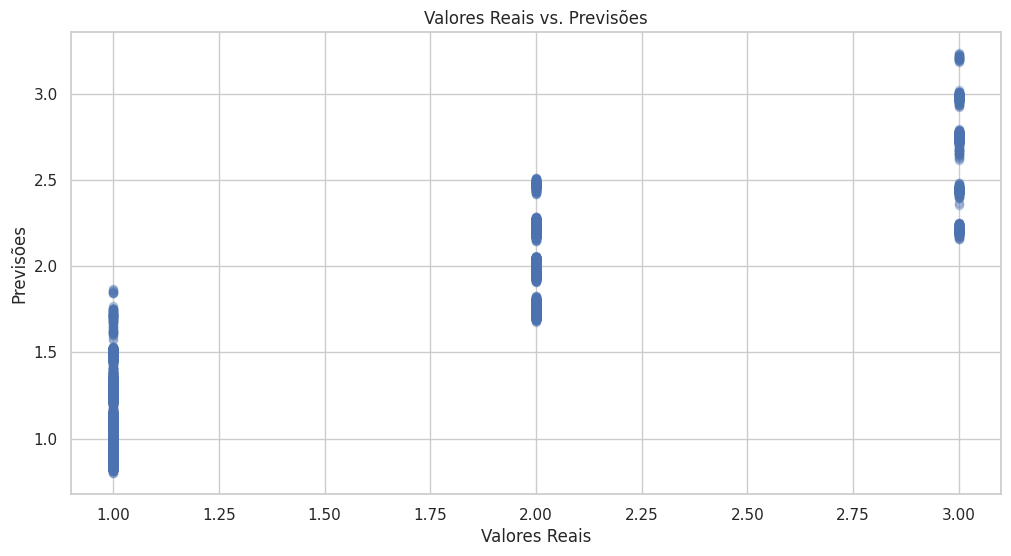

In [519]:
# Gráfico de Previsões vs. Valores Reais
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Valores Reais vs. Previsões')
plt.show()

## Ajustes de Modelo

In [520]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [521]:
# Definindo os parâmetros para ajuste
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

In [522]:
# Criar o modelo
rf = RandomForestRegressor()

In [523]:
# Criar o GridSearch
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [524]:
# Ajustar o modelo
grid_search.fit(X_train, y_train) # Essa etapa demorou cerca de 11 minutos

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [525]:
# Melhor modelo
best_model = grid_search.best_estimator_
best_model

RandomForestRegressor(max_depth=10, n_estimators=200)

In [526]:
y_pred = best_model.predict(X_test)

In [527]:
# Avaliando o Modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.004329838585696128
Mean Absolute Error: 0.008451426401045355
R2 Score: 0.9882942136882156


In [528]:
from sklearn.model_selection import cross_val_score

# Realizar validação cruzada
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'CV Mean Squared Error: {-cv_scores.mean()}')

CV Mean Squared Error: 0.004366292892504102


## Salvando o Modelo em .pkl

In [529]:
import joblib

# Salvar o modelo
joblib.dump(best_model, 'adv_works_model.pkl')

['adv_works_model.pkl']

## Importância das Features

In [531]:
feature_importances = best_model.feature_importances_

# Criar um DataFrame para visualização
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

In [536]:
top_n = 5
top_features = feature_importances_df.head(top_n)

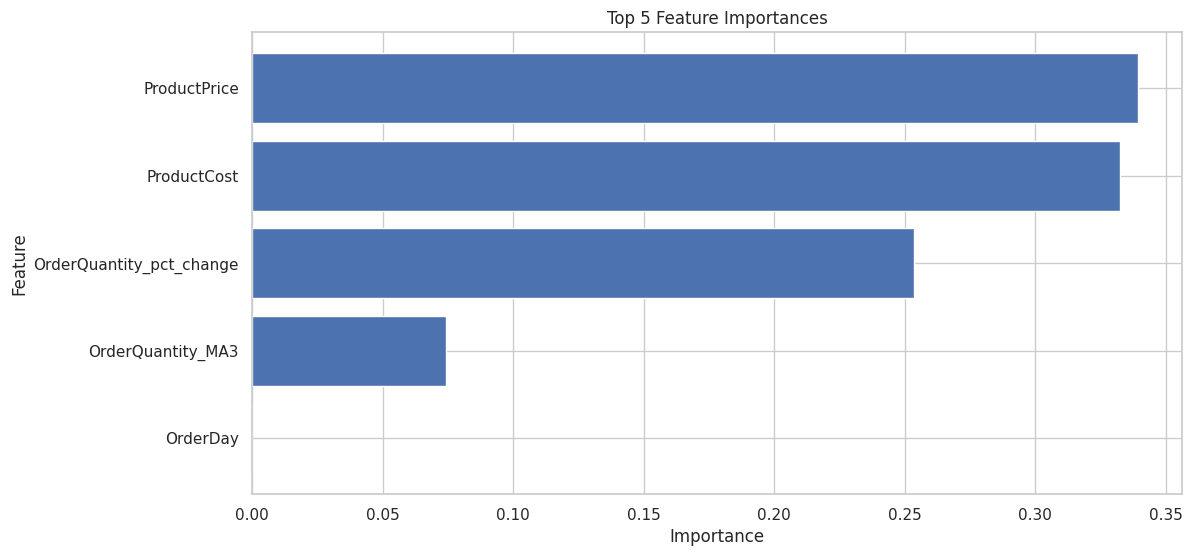

In [537]:
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
plt.show()